In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import mannwhitneyu

In [2]:
df = pd.read_csv('data/data.csv', sep=';')
df = df.drop(columns=['Number', 'Closed_date', 'Merge_date', 'Diff_MergeLastModify', 'Create_date', 'Diff_CreateNow'])

print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Situation             1107 non-null   object
 1   Nivel                 1107 non-null   object
 2   Imports               1107 non-null   int64 
 3   Changed_files         1107 non-null   int64 
 4   Changes               1107 non-null   int64 
 5   Deletion              1107 non-null   int64 
 6   Aditions              1107 non-null   int64 
 7   Size_body             1107 non-null   int64 
 8   PR_comments           1107 non-null   int64 
 9   PR_size_comments      1107 non-null   int64 
 10  Review_comments       1107 non-null   int64 
 11  Review_size_comments  1107 non-null   int64 
 12  Issue_comments        1107 non-null   int64 
 13  Issue_size_comments   1107 non-null   int64 
 14  Qtd_labels_pr         1107 non-null   int64 
 15  Qtd_labels_issue      1107 non-null   

,Situation,Nivel,Imports,Changed_files,Changes,Deletion,Aditions,Size_body,PR_comments,PR_size_comments,Review_comments,Review_size_comments,Issue_comments,Issue_size_comments,Qtd_labels_pr,Qtd_labels_issue,Commits
0,Open,Difficult,0,5,27,7,20,1100,8,1086,5,1086,7,1752,3,4,1
1,Open,Difficult,0,1,5,1,4,157,0,0,0,0,0,0,1,3,1
2,Open,Difficult,0,10,427,37,390,81,4,2598,8,2598,3,516,2,3,4
3,Open,Difficult,9,11,870,6,864,47,11,3886,14,3886,10,5529,3,4,3
4,Open,Difficult,4,15,106,46,60,334,5,0,0,0,3,525,2,4,4


In [3]:
# separar os dados em faceis/difíceis
dfEasy = df.loc[(df['Situation'] == 'Closed') & (df['Nivel'] == 'Easy')]
dfDifficult = df.loc[(df['Situation'] == 'Closed') & (df['Nivel'] == 'Difficult')]

In [4]:
y = dfEasy['Nivel']
X = dfEasy.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.043, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.044, shuffle=True)

dfTeste = pd.DataFrame(np.concatenate((dfDifficult.values, X_test), axis=0), columns=df.columns) 
dfValid =  pd.DataFrame(np.concatenate((dfDifficult.values, X_val), axis=0), columns=df.columns)
valid =  pd.DataFrame(X_val, columns=df.columns)
valid['Nivel'] = 'Easy valid'

dfAll = pd.DataFrame(np.concatenate((dfDifficult.values, X_test, valid.values), axis=0), columns=df.columns) 
dfAll.loc[dfAll['Nivel'] == 'Easy', 'Nivel'] = 'Easy Train'

len(X_train), len(X_test), len(X_val)

(890, 42, 42)

In [5]:
dfAll.groupby('Nivel').describe()

Situation                     Imports                  \
               count unique     top freq   count unique top freq   
Nivel                                                              
Difficult         42      1  Closed   42      42      5   0   32   
Easy Train        42      1  Closed   42      42      6   0   33   
Easy valid        42      1  Closed   42      42      6   0   34   

           Changed_files         ... Qtd_labels_pr      Qtd_labels_issue  \
                   count unique  ...           top freq            count   
Nivel                            ...                                       
Difficult             42     12  ...             1   16               42   
Easy Train            42      9  ...             0   23               42   
Easy valid            42     14  ...             0   21               42   

                           Commits                  
           unique top freq   count unique top freq  
Nivel                                               
Difficult       7   4    9      42      8   1   22  
Easy Train      4   3   21      42      6   1   30  
Easy valid      5   4   18      42      9   1   29  

[3 rows x 64 columns]

Bloxpot para o atributo:  Imports


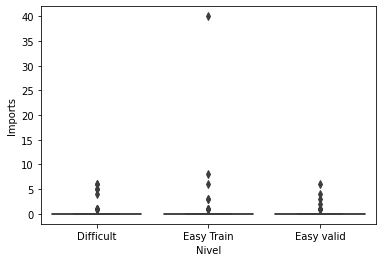

Dificil X Easy train:
p:  0.8832739894709248 
d:  -0.17034297754234498

Dificil X Easy valid:
p:  0.6789643633689721 
d:  0.19256246512030123 

Bloxpot para o atributo:  Changed_files


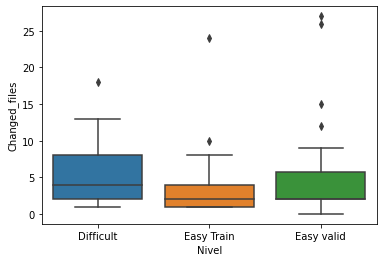

Dificil X Easy train:
p:  0.002253272236313718 
d:  0.48107811902796466

Dificil X Easy valid:
p:  0.10086294110835131 
d:  0.09528347913165881 

Bloxpot para o atributo:  Changes


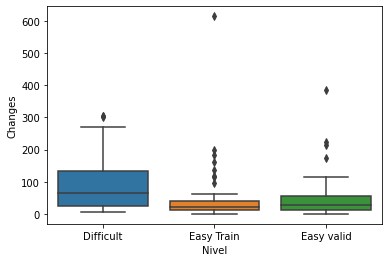

Dificil X Easy train:
p:  0.0003898199773615013 
d:  0.44260803299842094

Dificil X Easy valid:
p:  0.001488987752332867 
d:  0.5424713500132387 

Bloxpot para o atributo:  Deletion


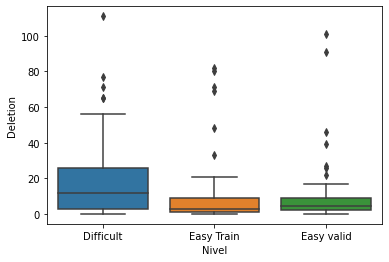

Dificil X Easy train:
p:  0.03706390920623674 
d:  0.33266032865516415

Dificil X Easy valid:
p:  0.09716708620033912 
d:  0.3553192535949292 

Bloxpot para o atributo:  Aditions


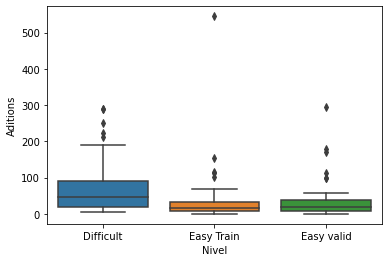

Dificil X Easy train:
p:  0.0013065985529472136 
d:  0.4095882786720953

Dificil X Easy valid:
p:  0.0041344639134393455 
d:  0.5166617450470121 

Bloxpot para o atributo:  Size_body


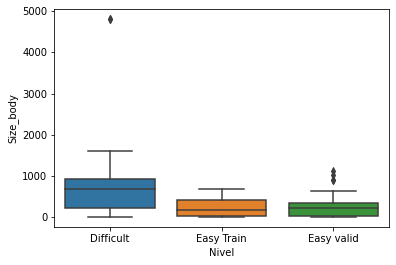

Dificil X Easy train:
p:  1.0540152945185672e-05 
d:  0.768061936346671

Dificil X Easy valid:
p:  0.00013550668861366926 
d:  0.7239331192374566 

Bloxpot para o atributo:  PR_comments


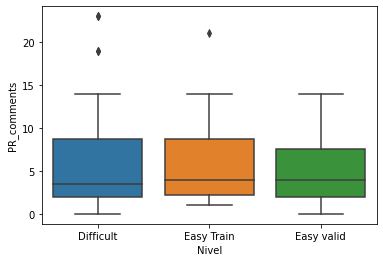

Dificil X Easy train:
p:  0.7997908211026552 
d:  0.14501266843786106

Dificil X Easy valid:
p:  0.6025222306173204 
d:  0.3415297888771592 

Bloxpot para o atributo:  PR_size_comments


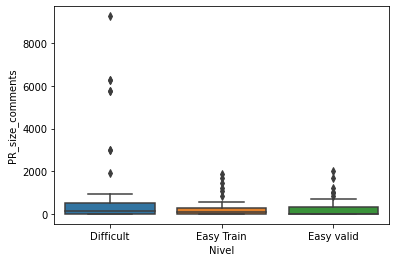

Dificil X Easy train:
p:  0.3073924400048083 
d:  0.5166598491157889

Dificil X Easy valid:
p:  0.05942492839398009 
d:  0.5304776503517152 

Bloxpot para o atributo:  Review_comments


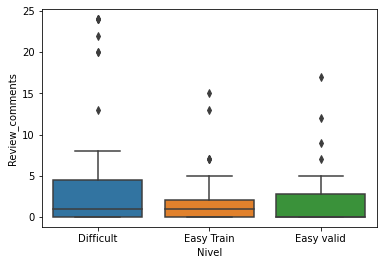

Dificil X Easy train:
p:  0.3657532799509217 
d:  0.4878374012102853

Dificil X Easy valid:
p:  0.06715521871872103 
d:  0.5037047148554058 

Bloxpot para o atributo:  Review_size_comments


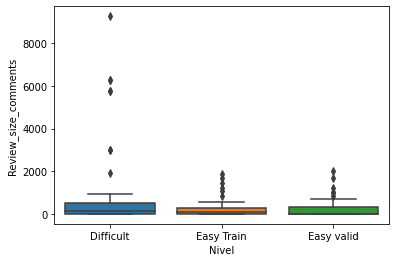

Dificil X Easy train:
p:  0.3073924400048083 
d:  0.5166598491157889

Dificil X Easy valid:
p:  0.05942492839398009 
d:  0.5304776503517152 

Bloxpot para o atributo:  Issue_comments


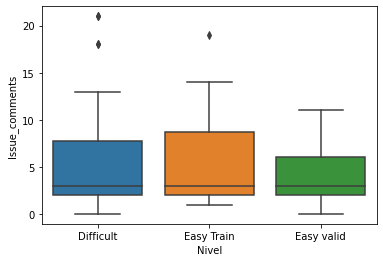

Dificil X Easy train:
p:  0.5127938040660069 
d:  0.07646718234037214

Dificil X Easy valid:
p:  0.6789643633689721 
d:  0.3424076255043413 

Bloxpot para o atributo:  Issue_size_comments


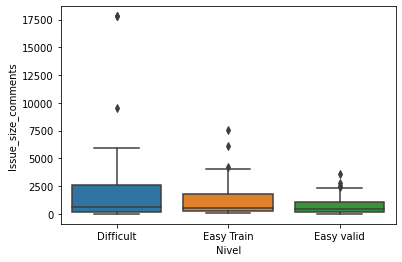

Dificil X Easy train:
p:  0.9751558813787179 
d:  0.3325524058206713

Dificil X Easy valid:
p:  0.14667258950836123 
d:  0.5291127765610246 

Bloxpot para o atributo:  Qtd_labels_pr


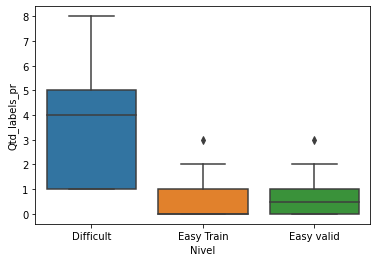

Dificil X Easy train:
p:  3.384622295211414e-11 
d:  1.6864938594740349

Dificil X Easy valid:
p:  2.8714866220816247e-11 
d:  1.7028926112438547 

Bloxpot para o atributo:  Qtd_labels_issue


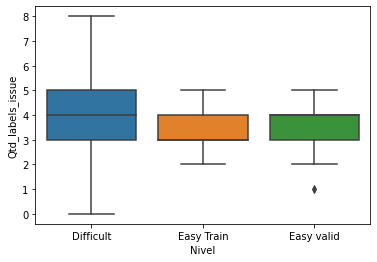

Dificil X Easy train:
p:  0.05355492256735239 
d:  0.3725150355345903

Dificil X Easy valid:
p:  0.2003318692437591 
d:  0.25020270434732694 

Bloxpot para o atributo:  Commits


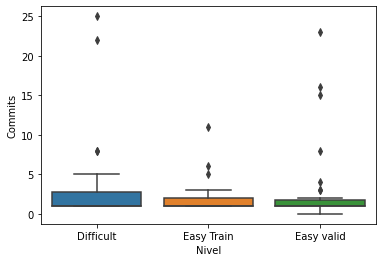

Dificil X Easy train:
p:  0.08671900542377693 
d:  0.3776497218723155

Dificil X Easy valid:
p:  0.07871516878695044 
d:  0.10465365263468875 



In [6]:
def cohend(d1, d2):
	n1, n2 = len(d1), len(d2)
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
	s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	u1, u2 = np.mean(d1), np.mean(d2)
	return (u1 - u2) / s

for column in dfAll.columns[2:]:
    print('Bloxpot para o atributo: ', column)
    sns.boxplot(data=dfAll, y=column, x='Nivel')
    plt.show()

    U1, p = mannwhitneyu(dfAll.loc[dfAll['Nivel'] == 'Difficult', column].values.tolist(), dfAll.loc[dfAll['Nivel'] == 'Easy Train', column].values.tolist(), method="exact")
    print('Dificil X Easy train:\np: ', p, '\nd: ', cohend(dfAll.loc[dfAll['Nivel'] == 'Difficult', column].values.tolist(), dfAll.loc[dfAll['Nivel'] == 'Easy Train', column].values.tolist()))

    U1, p = mannwhitneyu(dfAll.loc[dfAll['Nivel'] == 'Difficult', column].values.tolist(), dfAll.loc[dfAll['Nivel'] == 'Easy valid', column].values.tolist(), method="exact")
    print('\nDificil X Easy valid:\np: ', p, '\nd: ', cohend(dfAll.loc[dfAll['Nivel'] == 'Difficult', column].values.tolist(), dfAll.loc[dfAll['Nivel'] == 'Easy valid', column].values.tolist()), '\n')
